In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm

In [4]:
# mount google drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Datasets

In [5]:
#base_path = '/content/drive/MyDrive/Cogs 188/Cogs 188 Project/Datasets'
base_path = '/content/drive/MyDrive/COGSdataset'
# use mutation df to define original cancer levels
mutations_df = pd.read_csv(os.path.join(base_path, 'mutation-load_updated.txt'), sep = '\t')
# use immune df to define original immune cell levels
immune_df = pd.read_csv(os.path.join(base_path, 'TCGA.Kallisto.fullIDs.cibersort.relative.tsv'), sep = '\t')
# use cytokine df to define how cytokine affects immune cell levels
cytokine_df = pd.read_csv(os.path.join(base_path, 'panimmune_cytokine_network_all_edges_july202018.tsv'), sep = '\t')

# Data Processing and Cleaning

## Filter datasets to look at BRCA cancer cells

In [6]:
mutations_df = mutations_df[mutations_df['Cohort'] == 'BRCA']
# remove 0 values
mutations_df = mutations_df[mutations_df['Non-silent per Mb'] != 0]
mutations_df.head()

,Cohort,Patient_ID,Tumor_Sample_ID,Silent per Mb,Non-silent per Mb
564,BRCA,TCGA-EW-A1P1,TCGA-EW-A1P1-01,0.028661,0.028661
565,BRCA,TCGA-PL-A8LY,TCGA-PL-A8LY-01,0.021965,0.021965
566,BRCA,TCGA-A2-A25F,TCGA-A2-A25F-01,0.029638,0.059276
567,BRCA,TCGA-LL-A440,TCGA-LL-A440-01,0.000000,0.045303
568,BRCA,TCGA-AO-A03U,TCGA-AO-A03U-01,0.086896,0.115862


In [7]:
immune_df = immune_df[immune_df['CancerType'] == 'BRCA']
immune_df.head()

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE
512,TCGA.BH.A5J0.01A.11R.A27Q.07,BRCA,0.001898,0.023556,0.010481,0.095533,0.0,0.127552,0.0,0.095345,...,0.236180,0.019468,0.000000,0.035999,0.000000,0.0,0.0,0.014,0.192839,1.008533
513,TCGA.AR.A5QM.01A.11R.A27Q.07,BRCA,0.093505,0.000000,0.037465,0.096298,0.0,0.014914,0.0,0.054760,...,0.147804,0.000000,0.000000,0.191294,0.006266,0.0,0.0,0.020,0.177653,1.013417
514,TCGA.E9.A5FL.01A.11R.A27Q.07,BRCA,0.000000,0.076612,0.000323,0.073061,0.0,0.033787,0.0,0.065763,...,0.556232,0.042529,0.004490,0.030624,0.000000,0.0,0.0,0.000,0.330051,0.952726
515,TCGA.E9.A5UP.01A.11R.A28M.07,BRCA,0.000000,0.023995,0.000000,0.022826,0.0,0.000000,0.0,0.134052,...,0.174712,0.000000,0.158263,0.000000,0.052880,0.0,0.0,0.014,0.191652,1.029308
516,TCGA.E9.A5UO.01A.11R.A28M.07,BRCA,0.003190,0.001659,0.000000,0.054254,0.0,0.119234,0.0,0.016036,...,0.266624,0.000000,0.000000,0.064945,0.000000,0.0,0.0,0.022,0.170754,1.039347


## Deciding which immune cells to keep

In [8]:
# based on research and literature reviews we will keep CD8 T Cells, Natural Killer Cells (NK Cells), and M1 Macrophages
# we will now need to do additional data processing and cleaning for the immune_df and cytokine_df to keep only these cells

In [9]:
# look at the immune_df to find list of immune cells it includes
# we have subtypes of certain cells, for example NK has different subtypes that we need to account for
immune_df.columns

Index(['SampleID', 'CancerType', 'B.cells.naive', 'B.cells.memory',
       'Plasma.cells', 'T.cells.CD8', 'T.cells.CD4.naive',
       'T.cells.CD4.memory.resting', 'T.cells.CD4.memory.activated',
       'T.cells.follicular.helper', 'T.cells.regulatory..Tregs.',
       'T.cells.gamma.delta', 'NK.cells.resting', 'NK.cells.activated',
       'Monocytes', 'Macrophages.M0', 'Macrophages.M1', 'Macrophages.M2',
       'Dendritic.cells.resting', 'Dendritic.cells.activated',
       'Mast.cells.resting', 'Mast.cells.activated', 'Eosinophils',
       'Neutrophils', 'P.value', 'Correlation', 'RMSE'],
      dtype='object')

In [10]:
# now let us take a look at the immune cell panel for cytokine_df
# This includes generalized subtypes so we will only just need to filter out for our immune cells of interest
cytokine_df['To'].unique()

array(['CD4..T.cells', 'CD8..T.cells', 'NK.cells', 'CD70', 'HMGB1',
       'IL1B', 'TNFSF9', 'IL1A', 'VEGFA', 'CD19..B.cells', 'Eosinophils',
       'Macrophage.Monocyte.derived', 'Mast.cells', 'CD27', 'CCR3',
       'CXCR3', 'SDC1', 'IFNGR2', 'IL1R2', 'IL13RA1', 'IL13RA2', 'IL2RG',
       'IL4R', 'TNFRSF4', 'TRAF2', 'TNFRSF9', 'EPHB2', 'GPC1', 'TIGIT',
       'CTLA4', 'CD80', 'Dendritic.cells', 'CD276', 'TNFSF4', 'BTLA',
       'CCL5', 'HLA-A', 'HLA-B', 'HLA-C', 'ICAM1', 'TGFB1', 'CD40LG',
       'IFNG', 'TNFSF14', 'Neutrophils', 'CD79A', 'TNFRSF14', 'VTCN1',
       'ITGB2', 'CD40', 'CCR1', 'CCR4', 'CCR5', 'DARC', 'SDC4', 'SELP',
       'ERBB2', 'KIR3DL1', 'KIR3DL2', 'LILRB1', 'LILRB2', 'KLRD1',
       'KIR2DL1', 'KIR2DL3', 'KIR2DS4', 'LILRA3', 'THBD', 'IL2RA',
       'ITGAL', 'ITGAM', 'ITGAX', 'IFNAR2', 'IFNGR1', 'IL10RA', 'IL10RB',
       'CD28', 'IL1R1', 'IL1RAP', 'ADRB2', 'CD53', 'IL2RB', 'ITGB6',
       'ITGB8', 'LTBR', 'TNFRSF6B', 'TNFRSF18', 'PDCD1', 'LAG3', 'HAVCR2',
       'C

In [11]:
immune_df

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE
512,TCGA.BH.A5J0.01A.11R.A27Q.07,BRCA,0.001898,0.023556,0.010481,0.095533,0.000000,0.127552,0.0,0.095345,...,0.236180,0.019468,0.000000,0.035999,0.000000,0.000000,0.000000,0.014,0.192839,1.008533
513,TCGA.AR.A5QM.01A.11R.A27Q.07,BRCA,0.093505,0.000000,0.037465,0.096298,0.000000,0.014914,0.0,0.054760,...,0.147804,0.000000,0.000000,0.191294,0.006266,0.000000,0.000000,0.020,0.177653,1.013417
514,TCGA.E9.A5FL.01A.11R.A27Q.07,BRCA,0.000000,0.076612,0.000323,0.073061,0.000000,0.033787,0.0,0.065763,...,0.556232,0.042529,0.004490,0.030624,0.000000,0.000000,0.000000,0.000,0.330051,0.952726
515,TCGA.E9.A5UP.01A.11R.A28M.07,BRCA,0.000000,0.023995,0.000000,0.022826,0.000000,0.000000,0.0,0.134052,...,0.174712,0.000000,0.158263,0.000000,0.052880,0.000000,0.000000,0.014,0.191652,1.029308
516,TCGA.E9.A5UO.01A.11R.A28M.07,BRCA,0.003190,0.001659,0.000000,0.054254,0.000000,0.119234,0.0,0.016036,...,0.266624,0.000000,0.000000,0.064945,0.000000,0.000000,0.000000,0.022,0.170754,1.039347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763,TCGA.A7.A0DC.01B.04R.A22O.07,BRCA,0.000000,0.113939,0.040357,0.005743,0.067493,0.214965,0.0,0.000000,...,0.125661,0.000000,0.058962,0.278053,0.000000,0.000000,0.000000,0.138,0.078372,1.048953
1764,TCGA.A7.A0DC.01B.04R.A22O.07,BRCA,0.000000,0.133703,0.046857,0.018552,0.031506,0.225782,0.0,0.000000,...,0.104292,0.000000,0.078465,0.211148,0.000000,0.001334,0.000000,0.244,0.045592,1.056600
1765,TCGA.OL.A6VQ.01A.12R.A41B.07,BRCA,0.062215,0.000000,0.043416,0.091071,0.000000,0.277757,0.0,0.005438,...,0.216361,0.012523,0.000000,0.132275,0.039928,0.000000,0.000000,0.022,0.168588,1.012793
1766,TCGA.E9.A54Y.01A.11R.A466.07,BRCA,0.000000,0.149071,0.199703,0.085599,0.097004,0.000000,0.0,0.074908,...,0.234564,0.000000,0.016296,0.014008,0.004188,0.000000,0.010609,0.000,0.393584,0.924620


In [12]:
# we will now work with our immune_df
# we will filter out to only contain our immune cells of interest including the subtypes as well
revised_immune_df = immune_df[['SampleID', 'CancerType','T.cells.CD8', 'NK.cells.resting', 'NK.cells.activated', 'Macrophages.M1']]
revised_immune_df.head()

,SampleID,CancerType,T.cells.CD8,NK.cells.resting,NK.cells.activated,Macrophages.M1
512,TCGA.BH.A5J0.01A.11R.A27Q.07,BRCA,0.095533,0.000000,0.026325,0.093797
513,TCGA.AR.A5QM.01A.11R.A27Q.07,BRCA,0.096298,0.000000,0.000000,0.065808
514,TCGA.E9.A5FL.01A.11R.A27Q.07,BRCA,0.073061,0.000000,0.038870,0.024885
515,TCGA.E9.A5UP.01A.11R.A28M.07,BRCA,0.022826,0.052414,0.014184,0.000000
516,TCGA.E9.A5UO.01A.11R.A28M.07,BRCA,0.054254,0.052109,0.000000,0.020995


In [13]:
# now we will combine our NK subtypes by summing them together and remove those subytpes
revised_immune_df['NK.cells'] = revised_immune_df['NK.cells.resting'] + revised_immune_df['NK.cells.activated']
revised_immune_df = revised_immune_df.drop(columns = ['NK.cells.resting', 'NK.cells.activated'])
revised_immune_df.head()

<ipython-input-13-971fccd39513>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revised_immune_df['NK.cells'] = revised_immune_df['NK.cells.resting'] + revised_immune_df['NK.cells.activated']


,SampleID,CancerType,T.cells.CD8,Macrophages.M1,NK.cells
512,TCGA.BH.A5J0.01A.11R.A27Q.07,BRCA,0.095533,0.093797,0.026325
513,TCGA.AR.A5QM.01A.11R.A27Q.07,BRCA,0.096298,0.065808,0.000000
514,TCGA.E9.A5FL.01A.11R.A27Q.07,BRCA,0.073061,0.024885,0.038870
515,TCGA.E9.A5UP.01A.11R.A28M.07,BRCA,0.022826,0.000000,0.066598
516,TCGA.E9.A5UO.01A.11R.A28M.07,BRCA,0.054254,0.020995,0.052109


## Deciding which cytokines to keep

In [14]:
# to filter out cytokines we first need to filter out our cytokine_df to keep only our immune cells of interset
revised_cytokine_df = cytokine_df[cytokine_df['To'].isin(['CD8..T.cells', 'NK.cells', 'Macrophage.Monocyte.derived'])]
revised_cytokine_df.head()

,Subtype,From,To,Score
1,1,CXCR3,CD8..T.cells,2.116279
2,1,CXCR3,NK.cells,-1.076923
4,2,CXCR3,CD8..T.cells,5.393939
5,2,CXCR3,NK.cells,-1.037671
7,3,CXCR3,CD8..T.cells,2.849206


In [15]:
# now we want to see which cytokines are relevant
# we want to look at the value counts and keep the n number of cytokines that appear the most
revised_cytokine_df['From'].value_counts()

,count
From,
CXCR3,12
ITGB2,5
IL2RA,4
TNFRSF9,4
CD27,4
PDCD1,4
CD28,4
TNFRSF4,4
TLR4,3


In [16]:
# we will keep the top 7 genes
cytokine_panel = ['CXCR3', 'ITGB2', 'TNFRSF9', 'PDCD1', 'CD27', 'CD28', 'IL2RA']
# now filter out revised_cytokine_df to only keep that panel
revised_cytokine_df = revised_cytokine_df[revised_cytokine_df['From'].isin(cytokine_panel)]
revised_cytokine_df.head()

,Subtype,From,To,Score
1,1,CXCR3,CD8..T.cells,2.116279
2,1,CXCR3,NK.cells,-1.076923
4,2,CXCR3,CD8..T.cells,5.393939
5,2,CXCR3,NK.cells,-1.037671
7,3,CXCR3,CD8..T.cells,2.849206


# State Initialization


### Defining the State Space

In [17]:
# Define the number of cancer cells in simulation
number_of_cancer_cells = 10

In [18]:
# now we need to initialize the number of immune cells
# we will use the revised_immune_df to do this
# However the values in this df are a normalized expression level from (0-1).
# we will need to scale it to become a realistic number of immune cells
# to scale we will get our dataframe multiply it by 10 (scalar) then multiply it by number of cancer cells
# we will then randomly sample a row of this scaled dataset to get an initalization counat for immune cells
scaled_revised_immune_df = revised_immune_df.iloc[:, 2:] * 10 * number_of_cancer_cells
cd8_counts, m1_counts, nk_counts = scaled_revised_immune_df.sample(n=1).values[0]
cd8_counts, m1_counts, nk_counts

(np.float64(10.114708591505298),
 np.float64(11.014926665984198),
 np.float64(0.9019717882275701))

In [19]:
# now we will need to initalize proliferation rates
# to do this we will refer to the mutations_df
# we will use the non-silent per Mb values for this
# we will create the following funciton which will sample n number of proliferation rates corresponding to the distrubtion of the non-siler per Mb values from the dataset
def initialize_cancer_cell_levels(cancer_cell_level_df, bins = 200, n_cells = 10):
  # capture frequency and bin edges of distribution
  n, bin_edges, _ = plt.hist(cancer_cell_level_df['Non-silent per Mb'], bins = bins)
  # get bin probability based on distribution
  bin_probs = n / np.sum(n)
  # loop n_cell times and store initialization values in an array
  cancer_cell_levels_list = []
  for _ in range(n_cells):
    # select the bin
    selected_bin_index = np.random.choice(len(bin_probs), p = bin_probs)
    # select the value
    synthetic_value = np.random.uniform(bin_edges[selected_bin_index], bin_edges[selected_bin_index + 1])
    # append value to list
    cancer_cell_levels_list.append(synthetic_value)
  return cancer_cell_levels_list


[1.1331145666216242,
 0.1056628616761518,
 0.38737143643328026,
 2.956784111523831,
 0.3233910151911711,
 2.3501743629873038,
 2.1745795303452984,
 0.913308495251762,
 0.11916658674847695,
 3.0456506884815706]

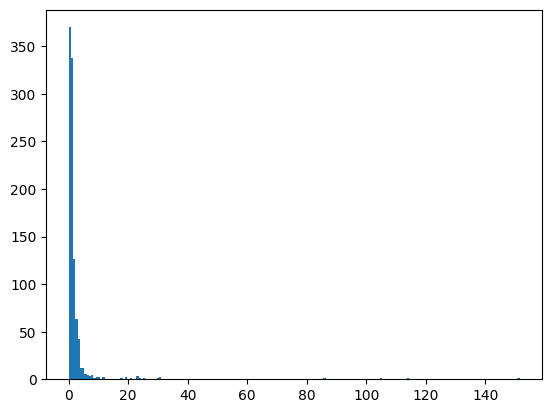

In [20]:
initialize_proliferation_rates = initialize_cancer_cell_levels(mutations_df, bins = 200, n_cells = number_of_cancer_cells)
initialize_proliferation_rates

we will now initialize our cell death probability. It would make more biological sense if each cell had their own probability but becuase of computational limititations we will just have one cell death probability.

To Calculate we will use the following equation:

$P_{death} = 1 - e^{-\beta_1 C_{CD8} -\beta_2 C_{NK} -\beta_3 C_{M1}}$

where $\beta$ are scalars and C is our counts for those immune cells

In [21]:
def calc_cell_death_probability(b1, b2, b3, cd8, nk, m1):
  return 1 - np.exp(-(b1*cd8 + b2*nk + b3*m1))

In [22]:
# these scalars are adjustable. We just need to maintain the relationship that cd8 is most impactful, followed my NK, followed by M1
cell_death_prob = calc_cell_death_probability(0.01, 0.005, 0.002, cd8_counts, nk_counts, m1_counts)
cell_death_prob

np.float64(0.11987100602357459)

In [23]:
# initialize cytokine levels. For simplicity we will just keep it pretty standary across all starts
CXCR3, ITGB2, TNFRSF9, PDCD1, CD27, CD28, IL2RA = (10 ,12, 25, 15, 10, 9, 18)
cytokine_count = CXCR3, ITGB2, TNFRSF9, PDCD1, CD27, CD28, IL2RA
cytokine_count

(10, 12, 25, 15, 10, 9, 18)

In [24]:
# initialziate the full state
initialize_state = {
    'Number of Cancer Cells': number_of_cancer_cells,
    'CD8 Count': cd8_counts,
    'M1 Count': m1_counts,
    'NK Count': nk_counts,
    'Tumor Proliferation Rates': initialize_proliferation_rates,
    'Cell Death Probability': cell_death_prob,
    'Cytokine Levels': cytokine_count
}
initialize_state

{'Number of Cancer Cells': 10,
 'CD8 Count': np.float64(10.114708591505298),
 'M1 Count': np.float64(11.014926665984198),
 'NK Count': np.float64(0.9019717882275701),
 'Tumor Proliferation Rates': [1.1331145666216242,
  0.1056628616761518,
  0.38737143643328026,
  2.956784111523831,
  0.3233910151911711,
  2.3501743629873038,
  2.1745795303452984,
  0.913308495251762,
  0.11916658674847695,
  3.0456506884815706],
 'Cell Death Probability': np.float64(0.11987100602357459),
 'Cytokine Levels': (10, 12, 25, 15, 10, 9, 18)}

# State Action Transitions

## Calculate proliferation rates

In [25]:
def calc_proliferation_rate(proliferation_rates, cd8, nk, m1, w1=1, w2=0.5, w3=2, K=1000):
  scalar = (1 - (w1*cd8 + w2*nk + w3*m1) / (K + cd8 + nk + m1))
  return [lambda_base * scalar for lambda_base in proliferation_rates]

In [26]:
initialize_proliferation_rates

[1.1331145666216242,
 0.1056628616761518,
 0.38737143643328026,
 2.956784111523831,
 0.3233910151911711,
 2.3501743629873038,
 2.1745795303452984,
 0.913308495251762,
 0.11916658674847695,
 3.0456506884815706]

In [27]:
calc_proliferation_rate(initialize_proliferation_rates, initialize_state['CD8 Count'], initialize_state['NK Count'], initialize_state['M1 Count'])

[np.float64(1.0969762615198058),
 np.float64(0.10229296701089408),
 np.float64(0.3750170394729681),
 np.float64(2.8624837031714434),
 np.float64(0.3130771391556617),
 np.float64(2.2752204962963747),
 np.float64(2.1052258914011883),
 np.float64(0.8841804423383691),
 np.float64(0.11536601918301131),
 np.float64(2.94851606762671)]

## Programming Cancer Cell Proliferation

In [28]:
# add new cells based on the proliferation rates
def proliferate_tumor_cells(proliferation_rates, scalar = 1.5):
  normalized_proliferation_rates = (proliferation_rates / (np.max(proliferation_rates) + 1e-8)) / scalar
  new_tumor_cells = []
  for rate, rate_normalized in zip(proliferation_rates, normalized_proliferation_rates):
    if np.random.rand() < rate_normalized:
      new_tumor_cells.append(rate)
  new_proliferation_rates = np.append(proliferation_rates, new_tumor_cells)
  new_cancer_cell_counts = len(new_proliferation_rates)
  return new_proliferation_rates, new_cancer_cell_counts

In [29]:
proliferate_tumor_cells(initialize_proliferation_rates)

(array([1.13311457, 0.10566286, 0.38737144, 2.95678411, 0.32339102,
        2.35017436, 2.17457953, 0.9133085 , 0.11916659, 3.04565069,
        1.13311457, 2.95678411, 2.35017436, 2.17457953, 3.04565069]),
 15)

## Programming Cancer Cell Death

In [30]:
def tumor_cell_death(proliferation_rates, cell_death_probability):
  normalized_proliferation_rates = proliferation_rates / (np.max(proliferation_rates) + 1e-8)
  new_proliferation_rates = []
  for rate, normalized_rate in zip(proliferation_rates, normalized_proliferation_rates):
    # we can assume that cell that proliferate more are more resistant to cell death as they are more likely to evolve
    # therefore since we have a set probability, we want to adjust this probability
    # we will adjust the probaiblity with the following equation:
    adjusted_cell_death_probability = cell_death_probability * (1 - normalized_rate)
    if np.random.rand() > adjusted_cell_death_probability:
      new_proliferation_rates.append(rate)
  new_cancer_cell_counts = len(new_proliferation_rates)
  return new_proliferation_rates, new_cancer_cell_counts

In [31]:
tumor_cell_death(initialize_proliferation_rates, cell_death_prob)

([1.1331145666216242,
  0.1056628616761518,
  0.38737143643328026,
  2.956784111523831,
  0.3233910151911711,
  2.3501743629873038,
  2.1745795303452984,
  0.913308495251762,
  0.11916658674847695,
  3.0456506884815706],
 10)

## State-Action Transition Rules

Each action affects the immune system and tumor cells in different ways:

- **Do Nothing** → No changes.
- **Chemotherapy** → Reduces the number of cancer cells based on probability.
- **Increase CXCR3** → Boosts CD8 cell recruitment, slightly increasing tumor cell death probability.
- **Increase ITGB2** → Enhances immune adhesion, increasing tumor cell death probability.
- **Increase TNFRSF9** → Increases NK cell activation, boosting tumor cell death probability.
- **Increase PDCD1** → Suppresses immune function, decreasing tumor cell death probability.
- **Increase CD27** → Enhances T-cell proliferation, increasing CD8 cell count.
- **Increase CD28** → Boosts general immune activation, increasing CD8 and NK cell counts.
- **Increase IL2RA** → Amplifies cytokine signaling, increasing tumor cell death probability.

These transitions define how different actions impact immune activity and tumor progression.


## Grouping Cytokines into 2-3 Actions

Handling each cytokine separately would be computationally expensive. To simplify, we categorize cytokines into three groups based on their role in immune and tumor cell interactions:

### 1. Pro-Immune Activation
- **Cytokines**: `CXCR3`, `CD27`, `CD28`, `IL2RA`
- **Effect**: Boosts immune response by increasing CD8/NK cell recruitment, leading to a higher tumor cell death probability.

### 2. Tumor Suppression & Adhesion
- **Cytokines**: `ITGB2`, `TNFRSF9`
- **Effect**: Enhances immune-tumor adhesion, increasing tumor cell death probability.

### 3. Immune Checkpoint (Suppressor Cytokines)
- **Cytokine**: `PDCD1`
- **Effect**: Inhibits immune function, reducing tumor cell death probability.

By grouping cytokines with similar functions, we optimize computational efficiency while maintaining biological accuracy.


In [32]:
# we will look at the cytokine_df to guide us on how immune cell levels will be affected by cytokines
pro_immune_activation_cytokine_df = revised_cytokine_df[revised_cytokine_df['From'].isin(['CXCR3', 'CD27', 'CD28', 'IL2RA'])][['To', 'Score']]
pro_immune_activation_cytokine_df.groupby('To').mean()

,Score
To,
CD8..T.cells,4.181393
Macrophage.Monocyte.derived,1.684519
NK.cells,-1.499453


In [33]:
tumor_suppression_cytokine_df = revised_cytokine_df[revised_cytokine_df['From'].isin(['ITGB2', 'TNFRSF9'])][['To', 'Score']]
tumor_suppression_cytokine_df.groupby('To').mean()

,Score
To,
CD8..T.cells,2.019206
Macrophage.Monocyte.derived,1.990811
NK.cells,-1.412206


In [34]:
immune_checkpoint_cytokine_df = revised_cytokine_df[revised_cytokine_df['From'].isin(['PDCD1'])][['To', 'Score']]
tumor_suppression_cytokine_df.groupby('To').mean()

,Score
To,
CD8..T.cells,2.019206
Macrophage.Monocyte.derived,1.990811
NK.cells,-1.412206


### State Transition Function

In [35]:
def state_transitions(state, action):
  # store our new state first as copy of the original
  new_state = state.copy()

  # Action: Do Nothing
  # Keep current state
  # run proliferation with current state parameters
  # run cell death with current state parameters
  if action == 'Do Nothing':
    # run the proliferation step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = proliferate_tumor_cells(new_state['Tumor Proliferation Rates'])
    # run the cell death step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = tumor_cell_death(new_state['Tumor Proliferation Rates'], new_state['Cell Death Probability'])

  # Action: Chemotherapy
  # Drastically increase cell death probability
  # reduce proliferation rates
  # decrease the number of immune cells also
  # decrease cytokine levels
  if action == 'Chemotherapy':
    # reduce proliferation rates
    for i, rate in enumerate(new_state['Tumor Proliferation Rates']):
      if np.random.rand() < 0.7:
        decrease_rate = np.random.uniform(0.3, 0.5)
        new_state['Tumor Proliferation Rates'][i] *= decrease_rate
    # run the proliferation step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = proliferate_tumor_cells(new_state['Tumor Proliferation Rates'], 10)
    # incrase cell death probability by 3x
    new_state['Cell Death Probability'] = min(0.9, new_state['Cell Death Probability'] * 3.5)
    # run the cell death step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = tumor_cell_death(new_state['Tumor Proliferation Rates'], new_state['Cell Death Probability'])

    # decrase the number of immune cells
    if np.random.rand() < 0.97:
      new_state['CD8 Count'] *= np.random.uniform(0.2, 0.5)
      new_state['NK Count'] *= np.random.uniform(0.3, 0.7)
      new_state['M1 Count'] *= np.random.uniform(0.5, 0.7)
      new_state['Cytokine Levels']
    # decrase the number of cytokines
    if np.random.rand() < 0.95:
      cxcr3 = new_state['Cytokine Levels'][0] * np.random.uniform(0.2, 0.5)
      itgb2 = new_state['Cytokine Levels'][1] * np.random.uniform(0.2, 0.5)
      tnfrsf9 = new_state['Cytokine Levels'][2] * np.random.uniform(0.2, 0.5)
      pdcd1 = new_state['Cytokine Levels'][3] * np.random.uniform(1.2, 1.5)
      cd27 = new_state['Cytokine Levels'][4] * np.random.uniform(0.2, 0.5)
      cd28 = new_state['Cytokine Levels'][5] * np.random.uniform(0.2, 0.5)
      il2ra = new_state['Cytokine Levels'][6] * np.random.uniform(0.2, 0.5)
      new_state['Cytokine Levels'] = cxcr3, itgb2, tnfrsf9, pdcd1, cd27, cd28, il2ra
    # update cell death probability
    #new_state['Cell Death Probability'] = calc_cell_death_probability(0.01, 0.005, 0.002, new_state['CD8 Count'], new_state['NK Count'], new_state['M1 Count'])

  # Action: Boost Pro Immune Cytokines
  # Use the table above to regulate changes to immune cells
  # increase tumor cell death probability
  if action == 'Boost Pro Immune Cytokines':
    # first boost the cytokine levels by 1.2
    cxcr3 = new_state['Cytokine Levels'][0] * 1.2
    itgb2 = new_state['Cytokine Levels'][1] * np.random.uniform(0.8, 0.95)
    tnfrsf9 = new_state['Cytokine Levels'][2] * np.random.uniform(0.8, 0.95)
    pdcd1 = new_state['Cytokine Levels'][3] * np.random.uniform(0.5, 0.8)
    cd27 = new_state['Cytokine Levels'][4] * 1.2
    cd28 = new_state['Cytokine Levels'][5] * 1.2
    il2ra = new_state['Cytokine Levels'][6] * 1.2
    new_state['Cytokine Levels'] = cxcr3, itgb2, tnfrsf9, pdcd1, cd27, cd28, il2ra
    # second adjust immune cell values with probability 0.9
    if np.random.rand() < 0.9:
      new_state['CD8 Count'] *= 4.18
      new_state['M1 Count'] *= 1.68
      new_state['NK Count'] /= 1.5
    # now let us adjust the proliferation levels
    new_state['Tumor Proliferation Rates'] = calc_proliferation_rate(new_state['Tumor Proliferation Rates'], new_state['CD8 Count'], new_state['NK Count'], new_state['M1 Count'])
    # run proliferation step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = proliferate_tumor_cells(new_state['Tumor Proliferation Rates'])
    # adjust cell death probability
    new_state['Cell Death Probability'] = calc_cell_death_probability(0.01, 0.005, 0.002, new_state['CD8 Count'], new_state['NK Count'], new_state['M1 Count'])
    # run cell death step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = tumor_cell_death(new_state['Tumor Proliferation Rates'], new_state['Cell Death Probability'])

  # Action: Boost Tumor Suppressing Cytokines
  # Use the table above to regulate changes to immune cells
  # increase tumor cell death probability
  if action == 'Boost Tumor Suppression Cytokines':
    # first boost the cytokine levels by 1.2x
    cxcr3 = new_state['Cytokine Levels'][0] * np.random.uniform(0.85, 0.95)
    itgb2 = new_state['Cytokine Levels'][1] * 1.2
    tnfrsf9 = new_state['Cytokine Levels'][2] * 1.2
    pdcd1 = new_state['Cytokine Levels'][3] * np.random.uniform(0.5, 0.8)
    cd27 = new_state['Cytokine Levels'][4] * np.random.uniform(0.85, 0.95)
    cd28 = new_state['Cytokine Levels'][5] * np.random.uniform(0.85, 0.95)
    il2ra = new_state['Cytokine Levels'][6] * np.random.uniform(0.85, 0.95)
    new_state['Cytokine Levels'] = cxcr3, itgb2, tnfrsf9, pdcd1, cd27, cd28, il2ra
    # second adjust immune cell values with probability 0.9
    if np.random.rand() < 0.9:
      new_state['CD8 Count'] *= 2.01
      new_state['M1 Count'] *= 1.99
      new_state['NK Count'] /= 1.41
    # now let us adjust the proliferation levels
    new_state['Tumor Proliferation Rates'] = calc_proliferation_rate(new_state['Tumor Proliferation Rates'], new_state['CD8 Count'], new_state['NK Count'], new_state['M1 Count'])
    # run proliferation step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = proliferate_tumor_cells(new_state['Tumor Proliferation Rates'])
    # adjust cell death probability
    new_state['Cell Death Probability'] = min(0.999, calc_cell_death_probability(0.01, 0.005, 0.002, new_state['CD8 Count'], new_state['NK Count'], new_state['M1 Count']) * 1.2)
    # run cell death step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = tumor_cell_death(new_state['Tumor Proliferation Rates'], new_state['Cell Death Probability'])


  # Action: Boost Immune Suppressing Cytokines
  # Use the table above to regulate changes to immune cells
  # decrease tumor cell death probability
  if action == 'Boost Immune Suppression Cytokines':
    # first boost the cytokine levels by 1.2x
    cxcr3 = new_state['Cytokine Levels'][0] * np.random.uniform(0.6, 0.8)
    itgb2 = new_state['Cytokine Levels'][1] * np.random.uniform(0.85, 0.95)
    tnfrsf9 = new_state['Cytokine Levels'][2] * np.random.uniform(0.85, 0.95)
    pdcd1 = new_state['Cytokine Levels'][3] * 1.2
    cd27 = new_state['Cytokine Levels'][4] * np.random.uniform(0.6, 0.8)
    cd28 = new_state['Cytokine Levels'][5] * np.random.uniform(0.6, 0.8)
    il2ra = new_state['Cytokine Levels'][6] * np.random.uniform(0.6, 0.8)
    new_state['Cytokine Levels'] = cxcr3, itgb2, tnfrsf9, pdcd1, cd27, cd28, il2ra
    # second adjust immune cell values with probability 0.9
    if np.random.rand() < 0.9:
      new_state['CD8 Count'] *= 2.01
      new_state['M1 Count'] *= 1.99
      new_state['NK Count'] /= 1.41
    # now let us adjust the proliferation levels
    new_state['Tumor Proliferation Rates'] = calc_proliferation_rate(new_state['Tumor Proliferation Rates'], new_state['CD8 Count'], new_state['NK Count'], new_state['M1 Count'])
    # run proliferation step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = proliferate_tumor_cells(new_state['Tumor Proliferation Rates'])
    # adjust cell death probability
    new_state['Cell Death Probability'] = min(0.999, calc_cell_death_probability(0.01, 0.005, 0.002, new_state['CD8 Count'], new_state['NK Count'], new_state['M1 Count']) * 0.5)
    # run cell death step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = tumor_cell_death(new_state['Tumor Proliferation Rates'], new_state['Cell Death Probability'])

  if new_state['Number of Cancer Cells'] == 0:
    return "All Cancer Cells Eliminated"
  # maintain stability across immune cells
  if new_state['CD8 Count'] + new_state['M1 Count'] + new_state['NK Count'] <= 10:
    return "Immune System Compromised"
  if new_state['CD8 Count'] + new_state['M1 Count'] + new_state['NK Count'] >= 200:
    return "Immune System attacking All Cells"
  return new_state


In [36]:
initialize_state

{'Number of Cancer Cells': 10,
 'CD8 Count': np.float64(10.114708591505298),
 'M1 Count': np.float64(11.014926665984198),
 'NK Count': np.float64(0.9019717882275701),
 'Tumor Proliferation Rates': [1.1331145666216242,
  0.1056628616761518,
  0.38737143643328026,
  2.956784111523831,
  0.3233910151911711,
  2.3501743629873038,
  2.1745795303452984,
  0.913308495251762,
  0.11916658674847695,
  3.0456506884815706],
 'Cell Death Probability': np.float64(0.11987100602357459),
 'Cytokine Levels': (10, 12, 25, 15, 10, 9, 18)}

In [37]:
# run boost pro immune cytokines
test1 = state_transitions(initialize_state, 'Boost Pro Immune Cytokines')
test1

{'Number of Cancer Cells': 10,
 'CD8 Count': np.float64(42.279481912492145),
 'M1 Count': np.float64(18.50507679885345),
 'NK Count': np.float64(0.6013145254850467),
 'Tumor Proliferation Rates': [np.float64(1.048145544160764),
  np.float64(0.35832355967609614),
  np.float64(2.7350633226604075),
  np.float64(0.2991408473415553),
  np.float64(2.1739415052357822),
  np.float64(2.0115140271740413),
  np.float64(0.11023062503349837),
  np.float64(2.8172660490279506),
  np.float64(2.7350633226604075),
  np.float64(2.0115140271740413)],
 'Cell Death Probability': np.float64(0.3704887443464083),
 'Cytokine Levels': (12.0,
  11.296356314884838,
  21.176275514692616,
  11.993626566236236,
  12.0,
  10.799999999999999,
  21.599999999999998)}

In [38]:
# run chemotherapy step
test2 = state_transitions(initialize_state, 'Chemotherapy')
test2

{'Number of Cancer Cells': 5,
 'CD8 Count': np.float64(5.034232582697249),
 'M1 Count': np.float64(6.000393177406783),
 'NK Count': np.float64(0.4905915060478496),
 'Tumor Proliferation Rates': [np.float64(0.17243436687055622),
  np.float64(1.1224900600921364),
  np.float64(0.9266479035720374),
  np.float64(0.055858867833950436),
  np.float64(1.0016680089859653)],
 'Cell Death Probability': np.float64(0.41954852108251106),
 'Cytokine Levels': (2.564925197835884,
  3.762302225483669,
  5.718994553645873,
  19.953529353750437,
  3.1895693152529727,
  2.6464410049748404,
  7.857375429373598)}

In [39]:
# run do nothing
test3 = state_transitions(initialize_state, 'Do Nothing')
test3

{'Number of Cancer Cells': 12,
 'CD8 Count': np.float64(10.114708591505298),
 'M1 Count': np.float64(11.014926665984198),
 'NK Count': np.float64(0.9019717882275701),
 'Tumor Proliferation Rates': [np.float64(0.4322292523530591),
  np.float64(0.04602369549512414),
  np.float64(0.17243436687055622),
  np.float64(1.1224900600921364),
  np.float64(0.14740818329781752),
  np.float64(0.9266479035720374),
  np.float64(0.9069428675835147),
  np.float64(0.4298323641473187),
  np.float64(1.0016680089859653),
  np.float64(1.1224900600921364),
  np.float64(0.14740818329781752),
  np.float64(0.9266479035720374)],
 'Cell Death Probability': np.float64(0.11987100602357459),
 'Cytokine Levels': (10, 12, 25, 15, 10, 9, 18)}

In [40]:
# run tumor suppression
test4 = state_transitions(initialize_state, 'Boost Tumor Suppression Cytokines')
test4

{'Number of Cancer Cells': 14,
 'CD8 Count': np.float64(20.33056426892565),
 'M1 Count': np.float64(21.919704065308554),
 'NK Count': np.float64(0.6396963037074965),
 'Tumor Proliferation Rates': [np.float64(0.40550122939141314),
  np.float64(0.043177700266257314),
  np.float64(0.16177143813076683),
  np.float64(1.053077960061814),
  np.float64(0.13829281388107956),
  np.float64(0.8693462139959611),
  np.float64(0.8508596902934397),
  np.float64(0.40325255901834084),
  np.float64(0.9397272555585358),
  np.float64(0.40550122939141314),
  np.float64(1.053077960061814),
  np.float64(0.8693462139959611),
  np.float64(0.8508596902934397),
  np.float64(0.9397272555585358)],
 'Cell Death Probability': np.float64(0.2657600570797704),
 'Cytokine Levels': (8.64366727590484,
  14.399999999999999,
  30.0,
  9.85399904617459,
  8.712012150420623,
  8.454995678446103,
  16.213663547442263)}

In [41]:
# run immune suppression
test_5 = state_transitions(initialize_state, 'Boost Immune Suppression Cytokines')
test_5

{'Number of Cancer Cells': 13,
 'CD8 Count': np.float64(20.33056426892565),
 'M1 Count': np.float64(21.919704065308554),
 'NK Count': np.float64(0.6396963037074965),
 'Tumor Proliferation Rates': [np.float64(0.40550122939141314),
  np.float64(0.043177700266257314),
  np.float64(0.16177143813076683),
  np.float64(1.053077960061814),
  np.float64(0.13829281388107956),
  np.float64(0.8693462139959611),
  np.float64(0.8508596902934397),
  np.float64(0.40325255901834084),
  np.float64(0.05240468907591986),
  np.float64(0.9397272555585358),
  np.float64(0.043177700266257314),
  np.float64(1.053077960061814),
  np.float64(0.40325255901834084)],
 'Cell Death Probability': np.float64(0.11073335711657101),
 'Cytokine Levels': (7.814945773057554,
  10.39607556439427,
  22.440762488825428,
  18.0,
  7.745484441129367,
  6.608618252181407,
  13.146566476831685)}

# Basic Model Implementation

In [42]:
def initialize_state(n_cancer_cells=10):
  # we already defined the number of cancer cells in the parameters
  # initialte number of immune cells
  scaled_revised_immune_df = revised_immune_df.iloc[:, 2:] * 10 * number_of_cancer_cells
  cd8_counts, m1_counts, nk_counts = scaled_revised_immune_df.sample(n=1).values[0]
  # initiate proliferation rates
  initialize_proliferation_rates = initialize_cancer_cell_levels(mutations_df, bins = 200, n_cells = number_of_cancer_cells)
  # initaialize tumor death probability
  cell_death_prob = calc_cell_death_probability(0.01, 0.005, 0.002, cd8_counts, nk_counts, m1_counts)
  # initialize cytokine counts
  CXCR3, ITGB2, TNFRSF9, PDCD1, CD27, CD28, IL2RA = (10 ,12, 25, 15, 10, 9, 18)
  cytokine_count = CXCR3, ITGB2, TNFRSF9, PDCD1, CD27, CD28, IL2RA
  state = {
      'Number of Cancer Cells': number_of_cancer_cells,
      'CD8 Count': cd8_counts,
      'M1 Count': m1_counts,
      'NK Count': nk_counts,
      'Tumor Proliferation Rates': initialize_proliferation_rates,
      'Cell Death Probability': cell_death_prob,
      'Cytokine Levels': cytokine_count
  }
  return state

In [43]:
def state_transitions(state, action):
  # store our new state first as copy of the original
  new_state = state.copy()

  # Action: Do Nothing
  # Keep current state
  # run proliferation with current state parameters
  # run cell death with current state parameters
  if action == 'Do Nothing':
    # run the proliferation step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = proliferate_tumor_cells(new_state['Tumor Proliferation Rates'])
    # run the cell death step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = tumor_cell_death(new_state['Tumor Proliferation Rates'], new_state['Cell Death Probability'])

  # Action: Chemotherapy
  # Drastically increase cell death probability
  # reduce proliferation rates
  # decrease the number of immune cells also
  # decrease cytokine levels
  if action == 'Chemotherapy':
    # reduce proliferation rates
    for i, rate in enumerate(new_state['Tumor Proliferation Rates']):
      if np.random.rand() < 0.7:
        decrease_rate = np.random.uniform(0.3, 0.5)
        new_state['Tumor Proliferation Rates'][i] *= decrease_rate
    # run the proliferation step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = proliferate_tumor_cells(new_state['Tumor Proliferation Rates'], 10)
    # incrase cell death probability by 3x
    new_state['Cell Death Probability'] = min(0.9, new_state['Cell Death Probability'] * 3.5)
    # run the cell death step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = tumor_cell_death(new_state['Tumor Proliferation Rates'], new_state['Cell Death Probability'])

    # decrase the number of immune cells
    if np.random.rand() < 0.97:
      new_state['CD8 Count'] *= np.random.uniform(0.2, 0.5)
      new_state['NK Count'] *= np.random.uniform(0.3, 0.7)
      new_state['M1 Count'] *= np.random.uniform(0.5, 0.7)
      new_state['Cytokine Levels']
    # decrase the number of cytokines
    if np.random.rand() < 0.95:
      cxcr3 = new_state['Cytokine Levels'][0] * np.random.uniform(0.2, 0.5)
      itgb2 = new_state['Cytokine Levels'][1] * np.random.uniform(0.2, 0.5)
      tnfrsf9 = new_state['Cytokine Levels'][2] * np.random.uniform(0.2, 0.5)
      pdcd1 = new_state['Cytokine Levels'][3] * np.random.uniform(1.2, 1.5)
      cd27 = new_state['Cytokine Levels'][4] * np.random.uniform(0.2, 0.5)
      cd28 = new_state['Cytokine Levels'][5] * np.random.uniform(0.2, 0.5)
      il2ra = new_state['Cytokine Levels'][6] * np.random.uniform(0.2, 0.5)
      new_state['Cytokine Levels'] = cxcr3, itgb2, tnfrsf9, pdcd1, cd27, cd28, il2ra
    # update cell death probability
    #new_state['Cell Death Probability'] = calc_cell_death_probability(0.01, 0.005, 0.002, new_state['CD8 Count'], new_state['NK Count'], new_state['M1 Count'])

  # Action: Boost Pro Immune Cytokines
  # Use the table above to regulate changes to immune cells
  # increase tumor cell death probability
  if action == 'Boost Pro Immune Cytokines':
    # first boost the cytokine levels by 1.2
    cxcr3 = new_state['Cytokine Levels'][0] * 1.2
    itgb2 = new_state['Cytokine Levels'][1] * np.random.uniform(0.8, 0.95)
    tnfrsf9 = new_state['Cytokine Levels'][2] * np.random.uniform(0.8, 0.95)
    pdcd1 = new_state['Cytokine Levels'][3] * np.random.uniform(0.5, 0.8)
    cd27 = new_state['Cytokine Levels'][4] * 1.2
    cd28 = new_state['Cytokine Levels'][5] * 1.2
    il2ra = new_state['Cytokine Levels'][6] * 1.2
    new_state['Cytokine Levels'] = cxcr3, itgb2, tnfrsf9, pdcd1, cd27, cd28, il2ra
    # second adjust immune cell values with probability 0.9
    if np.random.rand() < 0.9:
      new_state['CD8 Count'] *= 4.18
      new_state['M1 Count'] *= 1.68
      new_state['NK Count'] /= 1.5
    # now let us adjust the proliferation levels
    new_state['Tumor Proliferation Rates'] = calc_proliferation_rate(new_state['Tumor Proliferation Rates'], new_state['CD8 Count'], new_state['NK Count'], new_state['M1 Count'])
    # run proliferation step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = proliferate_tumor_cells(new_state['Tumor Proliferation Rates'])
    # adjust cell death probability
    new_state['Cell Death Probability'] = calc_cell_death_probability(0.01, 0.005, 0.002, new_state['CD8 Count'], new_state['NK Count'], new_state['M1 Count'])
    # run cell death step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = tumor_cell_death(new_state['Tumor Proliferation Rates'], new_state['Cell Death Probability'])

  # Action: Boost Tumor Suppressing Cytokines
  # Use the table above to regulate changes to immune cells
  # increase tumor cell death probability
  if action == 'Boost Tumor Suppression Cytokines':
    # first boost the cytokine levels by 1.2x
    cxcr3 = new_state['Cytokine Levels'][0] * np.random.uniform(0.85, 0.95)
    itgb2 = new_state['Cytokine Levels'][1] * 1.2
    tnfrsf9 = new_state['Cytokine Levels'][2] * 1.2
    pdcd1 = new_state['Cytokine Levels'][3] * np.random.uniform(0.5, 0.8)
    cd27 = new_state['Cytokine Levels'][4] * np.random.uniform(0.85, 0.95)
    cd28 = new_state['Cytokine Levels'][5] * np.random.uniform(0.85, 0.95)
    il2ra = new_state['Cytokine Levels'][6] * np.random.uniform(0.85, 0.95)
    new_state['Cytokine Levels'] = cxcr3, itgb2, tnfrsf9, pdcd1, cd27, cd28, il2ra
    # second adjust immune cell values with probability 0.9
    if np.random.rand() < 0.9:
      new_state['CD8 Count'] *= 2.01
      new_state['M1 Count'] *= 1.99
      new_state['NK Count'] /= 1.41
    # now let us adjust the proliferation levels
    new_state['Tumor Proliferation Rates'] = calc_proliferation_rate(new_state['Tumor Proliferation Rates'], new_state['CD8 Count'], new_state['NK Count'], new_state['M1 Count'])
    # run proliferation step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = proliferate_tumor_cells(new_state['Tumor Proliferation Rates'])
    # adjust cell death probability
    new_state['Cell Death Probability'] = min(0.999, calc_cell_death_probability(0.01, 0.005, 0.002, new_state['CD8 Count'], new_state['NK Count'], new_state['M1 Count']) * 1.2)
    # run cell death step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = tumor_cell_death(new_state['Tumor Proliferation Rates'], new_state['Cell Death Probability'])


  # Action: Boost Immune Suppressing Cytokines
  # Use the table above to regulate changes to immune cells
  # decrease tumor cell death probability
  if action == 'Boost Immune Suppression Cytokines':
    # first boost the cytokine levels by 1.2x
    cxcr3 = new_state['Cytokine Levels'][0] * np.random.uniform(0.6, 0.8)
    itgb2 = new_state['Cytokine Levels'][1] * np.random.uniform(0.85, 0.95)
    tnfrsf9 = new_state['Cytokine Levels'][2] * np.random.uniform(0.85, 0.95)
    pdcd1 = new_state['Cytokine Levels'][3] * 1.2
    cd27 = new_state['Cytokine Levels'][4] * np.random.uniform(0.6, 0.8)
    cd28 = new_state['Cytokine Levels'][5] * np.random.uniform(0.6, 0.8)
    il2ra = new_state['Cytokine Levels'][6] * np.random.uniform(0.6, 0.8)
    new_state['Cytokine Levels'] = cxcr3, itgb2, tnfrsf9, pdcd1, cd27, cd28, il2ra
    # second adjust immune cell values with probability 0.9
    if np.random.rand() < 0.9:
      new_state['CD8 Count'] *= 2.01
      new_state['M1 Count'] *= 1.99
      new_state['NK Count'] /= 1.41
    # now let us adjust the proliferation levels
    new_state['Tumor Proliferation Rates'] = calc_proliferation_rate(new_state['Tumor Proliferation Rates'], new_state['CD8 Count'], new_state['NK Count'], new_state['M1 Count'])
    # run proliferation step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = proliferate_tumor_cells(new_state['Tumor Proliferation Rates'])
    # adjust cell death probability
    new_state['Cell Death Probability'] = min(0.999, calc_cell_death_probability(0.01, 0.005, 0.002, new_state['CD8 Count'], new_state['NK Count'], new_state['M1 Count']) * 0.5)
    # run cell death step
    new_state['Tumor Proliferation Rates'], new_state['Number of Cancer Cells'] = tumor_cell_death(new_state['Tumor Proliferation Rates'], new_state['Cell Death Probability'])
  return new_state


In [44]:
# to collect rewards, we will look at new state after action and compare to previous state
def collect_rewards(state, next_state):
  reward = 0
  # first initiate terminal state of eliminating tumor
  if state['Number of Cancer Cells'] == 0:
    reward += 100000000
  # if tumor gets too big it kills patient:
  if state['Number of Cancer Cells'] >= 5000000:
    reward -= 10000
  # if we have dangerously low immune cell counts add signifcant penalty (patient death)
  if state['CD8 Count'] + state['M1 Count'] + state['NK Count'] <= 1e-6:
    reward -= 10000
  # if we have dangerously high immune cell counts add signifcant penalty (patient death)
  if state['CD8 Count'] + state['M1 Count'] + state['NK Count'] >= 19000:
    reward -= 10000
  # eliminating cancer cell add reward
  number_of_killed_cells = state['Number of Cancer Cells'] - next_state['Number of Cancer Cells']
  reward += number_of_killed_cells * 1000
  # add reward for cell death probability
  cell_death_diff = next_state['Cell Death Probability'] - state['Cell Death Probability']
  reward += cell_death_diff * 1000
  # add reward for increasing number of immune cells
  cd8_diff = next_state['CD8 Count'] - state['CD8 Count']
  m1_diff = next_state['M1 Count'] - state['M1 Count']
  nk_diff = next_state['NK Count'] - state['NK Count']
  reward += cd8_diff + 0.5 * m1_diff + nk_diff
  return reward

In [45]:
action_space = ['Do Nothing', 'Chemotherapy', 'Boost Pro Immune Cytokines', 'Boost Tumor Suppression Cytokines', 'Boost Immune Suppression Cytokines']

In [46]:
import seaborn as sns
def run_episode(n_cancer_cells = 10):
  num_actions = 0
  state = initialize_state(n_cancer_cells)
  total_rewards = 0
  # way to track tumor size over time
  tumor_size = [state['Number of Cancer Cells']]
  while True:
    # check for terminal states
    if state['Number of Cancer Cells'] == 0:
      break
    elif state['Number of Cancer Cells'] >= 5000000:
      break
    elif state['CD8 Count'] + state['M1 Count'] + state['NK Count'] <= 1e-6:
      break
    elif state['CD8 Count'] + state['M1 Count'] + state['NK Count'] >= 19000:
      break
    else:
      action = random.choice(action_space)
      next_state = state_transitions(state, action)
      reward = collect_rewards(state, next_state)
      total_rewards += reward
      state = next_state
      tumor_size.append(state['Number of Cancer Cells'])
    num_actions += 1
  return state, total_rewards, num_actions, tumor_size

({'Number of Cancer Cells': 0,
  'CD8 Count': np.float64(1807.5651062315426),
  'M1 Count': np.float64(1079.7629553052066),
  'NK Count': np.float64(2.9227660108230548e-08),
  'Tumor Proliferation Rates': [],
  'Cell Death Probability': np.float64(0.9999999983708003),
  'Cytokine Levels': (2.1910482089820625e-06,
   6.749094426792803e-06,
   1.527574971475744e-05,
   6.873668077673131,
   1.9198950173437855e-07,
   6.184714707952546e-07,
   1.199167879495462e-06)},
 np.float64(13187.146072075819),
 47,
 [10,
  8,
  11,
  9,
  7,
  7,
  9,
  11,
  18,
  18,
  16,
  20,
  26,
  9,
  4,
  6,
  8,
  12,
  20,
  33,
  55,
  82,
  130,
  200,
  320,
  507,
  820,
  1313,
  2100,
  3387,
  2207,
  2437,
  3490,
  2123,
  994,
  408,
  139,
  169,
  219,
  297,
  354,
  512,
  818,
  1335,
  884,
  942,
  543,
  0])

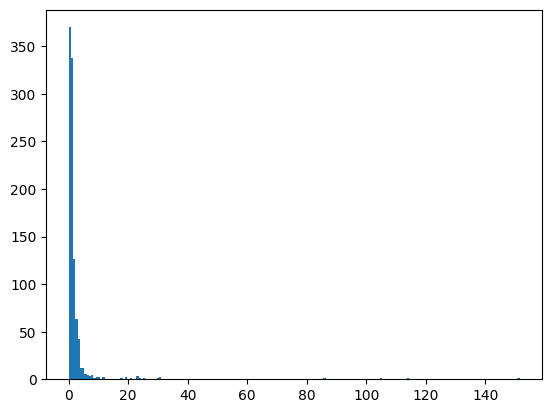

In [47]:
run_episode(150)

np.float64(7740.540518510696)

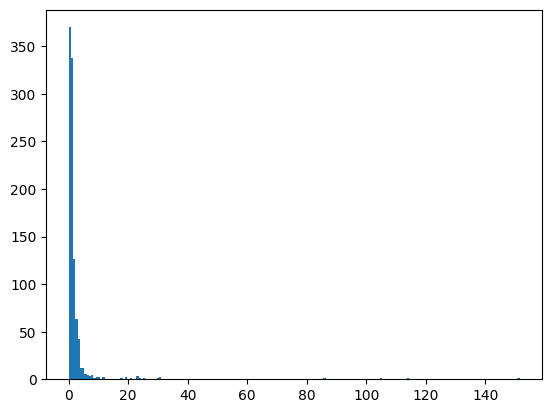

In [48]:
state = initialize_state()
total_rewards = 0
for _ in range(10000):
  # check for terminal states
  if state['Number of Cancer Cells'] == 0:
    break
  elif state['CD8 Count'] + state['M1 Count'] + state['NK Count'] <= 10:
    break
  elif state['CD8 Count'] + state['M1 Count'] + state['NK Count'] >= 200:
    break
  else:
    action = random.choice(action_space)
    next_state = state_transitions(state, action)
    reward = collect_rewards(state, next_state)
    total_rewards += reward
    state = next_state
total_rewards


Episode 100 completed. Successful episodes so far: 42
Episode 200 completed. Successful episodes so far: 69
Episode 300 completed. Successful episodes so far: 96
Episode 400 completed. Successful episodes so far: 127
Episode 500 completed. Successful episodes so far: 157
Episode 600 completed. Successful episodes so far: 186
Episode 700 completed. Successful episodes so far: 210
Episode 800 completed. Successful episodes so far: 234
Episode 900 completed. Successful episodes so far: 262
Episode 1000 completed. Successful episodes so far: 292


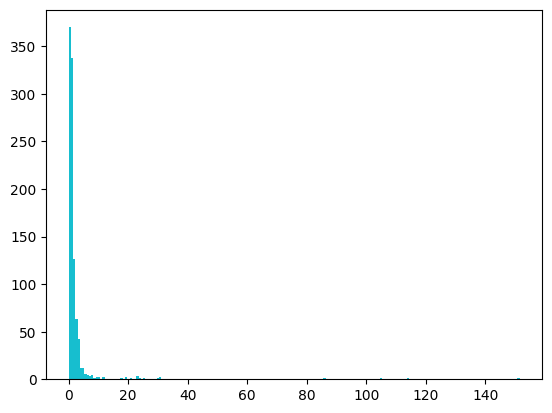

In [51]:
# Initialize Q-table for Monte Carlo
action_space = ['Do Nothing', 'Chemotherapy', 'Boost Pro Immune Cytokines', 'Boost Tumor Suppression Cytokines', 'Boost Immune Suppression Cytokines']
state_space_size = 1000  # Example: Define a discrete state space size
Q_table = np.zeros((state_space_size, len(action_space)))

# Helper function to discretize the state
def discretize_state(state):
    # Example: Discretize based on the number of cancer cells
    cancer_cells = state['Number of Cancer Cells']
    return min(int(cancer_cells / 5000), state_space_size - 1)  # Adjust based on your state space

# Monte Carlo algorithm
def monte_carlo(episodes=1000, gamma=0.99):
    returns_sum = np.zeros((state_space_size, len(action_space)))
    returns_count = np.zeros((state_space_size, len(action_space)))
    successful_episodes = 0  # Counter for successful episodes

    for episode in range(1, episodes + 1):  # Start from 1 for better readability in print statements
        state = initialize_state()
        episode_history = []
        success = False  # Flag to track success

        while True:
            # Discretize the state
            discrete_state = discretize_state(state)

            # Choose action using epsilon-greedy policy
            epsilon = 0.1
            if random.uniform(0, 1) < epsilon:
                action_index = random.randint(0, len(action_space) - 1)
            else:
                action_index = np.argmax(Q_table[discrete_state])

            action = action_space[action_index]

            # Take action and observe next state and reward
            next_state = state_transitions(state, action)
            reward = collect_rewards(state, next_state)

            # Store the experience
            episode_history.append((discrete_state, action_index, reward))

            # Terminal conditions
            if next_state['Number of Cancer Cells'] == 0:
                success = True  # Mark episode as successful
                break
            if next_state['Number of Cancer Cells'] >= 5000000:
                break
            if state['CD8 Count'] + state['M1 Count'] + state['NK Count'] <= 1e-6:
                break
            if state['CD8 Count'] + state['M1 Count'] + state['NK Count'] >= 19000:
                break

            state = next_state

        # Count successful episodes
        if success:
            successful_episodes += 1

        # Update Q-table using Monte Carlo
        G = 0
        for t in reversed(range(len(episode_history))):
            discrete_state, action_index, reward = episode_history[t]
            G = gamma * G + reward
            returns_sum[discrete_state, action_index] += G
            returns_count[discrete_state, action_index] += 1
            Q_table[discrete_state, action_index] = returns_sum[discrete_state, action_index] / returns_count[discrete_state, action_index]

        # Print progress every 25 episodes, including the number of successful episodes
        if episode % 100 == 0:
            print(f"Episode {episode} completed. Successful episodes so far: {successful_episodes}")

    return Q_table

# Run Monte Carlo
Q_table_mc = monte_carlo(episodes=1000)


In [57]:
import random
import numpy as np

# Initialize Q-table for Q-Learning
state_space_size = 1000  # Example: Define a discrete state space size
Q_table = np.zeros((state_space_size, len(action_space)))

# Helper function to discretize the state
def discretize_state(state):
    # Example: Discretize based on the number of cancer cells
    cancer_cells = state['Number of Cancer Cells']
    return min(int(cancer_cells / 5000), state_space_size - 1)  # Adjust based on your state space

# Q-Learning algorithm
def q_learning(episodes=1000, alpha=0.1, gamma=0.99, initial_epsilon=1.0, min_epsilon=0.01, decay_rate=0.995):
    successful_episodes = 0  # Counter for successful episodes
    epsilon = initial_epsilon  # Initialize epsilon for epsilon-greedy policy

    for episode in range(episodes):
        state = initialize_state()
        success = False  # Track whether the episode is successful

        while True:
            # Discretize the state
            discrete_state = discretize_state(state)

            # Choose action using epsilon-greedy policy
            if random.uniform(0, 1) < epsilon:
                action_index = random.randint(0, len(action_space) - 1)  # Explore
            else:
                action_index = np.argmax(Q_table[discrete_state])  # Exploit

            action = action_space[action_index]

            # Take action and observe next state and reward
            next_state = state_transitions(state, action)
            reward = collect_rewards(state, next_state)

            # Discretize the next state
            next_discrete_state = discretize_state(next_state)

            # Update Q-table
            Q_table[discrete_state, action_index] += alpha * (
                reward + gamma * np.max(Q_table[next_discrete_state]) - Q_table[discrete_state, action_index]
            )

            # Terminal conditions
            if next_state['Number of Cancer Cells'] == 0:
                success = True  # Mark episode as successful
                break
            if next_state['Number of Cancer Cells'] >= 5000000:
                break
            if state['CD8 Count'] + state['M1 Count'] + state['NK Count'] <= 1e-6:
                break
            if state['CD8 Count'] + state['M1 Count'] + state['NK Count'] >= 19000:
                break

            state = next_state

        # Count successful episodes
        if success:
            successful_episodes += 1

        # Decay epsilon to reduce exploration over time
        epsilon = max(min_epsilon, epsilon * decay_rate)

        # Print progress every 100 episodes
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1} completed. Successful episodes so far: {successful_episodes}, Epsilon: {epsilon:.4f}")

    return Q_table, successful_episodes

# Run Q-Learning
Q_table_ql, successful_episodes = q_learning(episodes=1000)
print(f"Total Successful Episodes: {successful_episodes}")

Episode 100 completed. Successful episodes so far: 75, Epsilon: 0.6058
Episode 200 completed. Successful episodes so far: 160, Epsilon: 0.3670
Episode 300 completed. Successful episodes so far: 210, Epsilon: 0.2223
Episode 400 completed. Successful episodes so far: 275, Epsilon: 0.1347
Episode 500 completed. Successful episodes so far: 310, Epsilon: 0.0816
Episode 600 completed. Successful episodes so far: 360, Epsilon: 0.0494
Episode 700 completed. Successful episodes so far: 405, Epsilon: 0.0299
Episode 800 completed. Successful episodes so far: 440, Epsilon: 0.0181
Episode 900 completed. Successful episodes so far: 470, Epsilon: 0.0110
Episode 1000 completed. Successful episodes so far: 491, Epsilon: 0.0100
Total Successful Episodes: 491


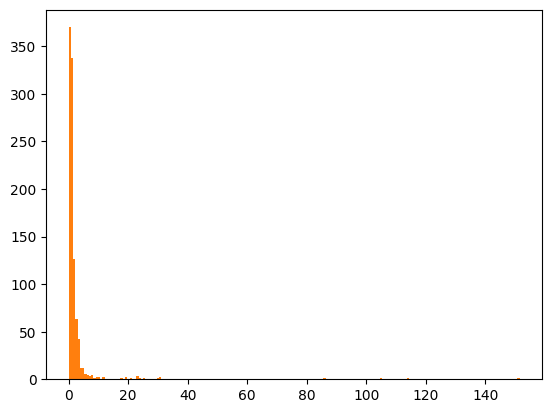

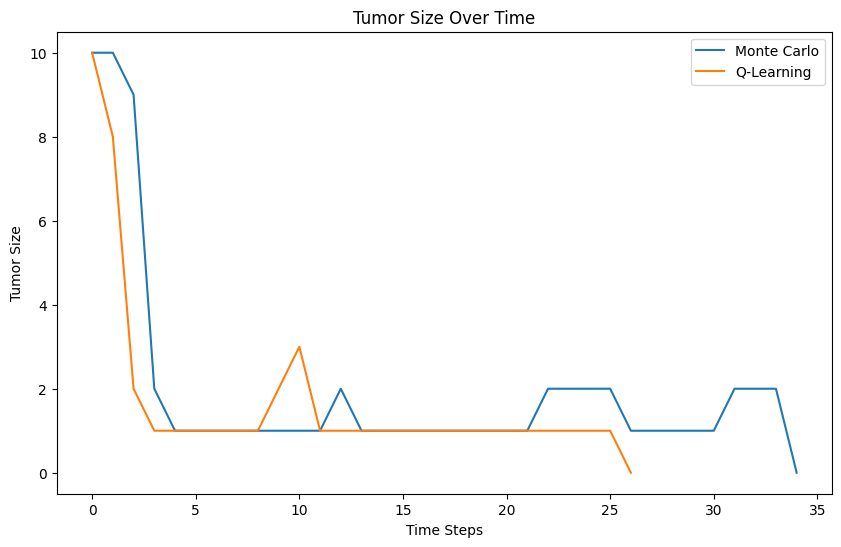

In [55]:
def test_policy(Q_table, n_cancer_cells=10):
    state = initialize_state(n_cancer_cells)
    tumor_size = [state['Number of Cancer Cells']]

    while True:
        discrete_state = discretize_state(state)
        action_index = np.argmax(Q_table[discrete_state])
        action = action_space[action_index]
        next_state = state_transitions(state, action)
        tumor_size.append(next_state['Number of Cancer Cells'])
        if next_state['Number of Cancer Cells'] == 0 or next_state['Number of Cancer Cells'] >= 5000000:
            break
        state = next_state
    return tumor_size
tumor_size_mc = test_policy(Q_table_mc, n_cancer_cells=150)
tumor_size_ql = test_policy(Q_table_ql, n_cancer_cells=150)
plt.figure(figsize=(10, 6))
plt.plot(tumor_size_mc, label='Monte Carlo')
plt.plot(tumor_size_ql, label='Q-Learning')
plt.xlabel('Time Steps')
plt.ylabel('Tumor Size')
plt.legend()
plt.title('Tumor Size Over Time')
plt.show()